In [32]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime import lime_tabular
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image as PILImage
from io import BytesIO


In [33]:
# Carica il dataset con il separatore corretto
file_path = '/home/lollo/Thesis/Python/data/data_mapped.csv'
data = pd.read_csv(file_path, delimiter=';')

In [34]:
# Encode categorical features
data_encoded = data.copy()

# List categorical columns
categorical_cols = data_encoded.select_dtypes(include=['object']).columns

# Initialize the label encoder
label_encoders = {col: LabelEncoder() for col in categorical_cols}

# Apply label encoding to each categorical column
for col, encoder in label_encoders.items():
    data_encoded[col] = encoder.fit_transform(data_encoded[col])

# Define the features (X) and the target (y)
X = data_encoded.drop('Target', axis=1)
y = data_encoded['Target']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
columns_to_include = [
    'Marital status', 'Application order', 'Admission grade',
    'Gender', 'Age at enrollment', 'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)', 'GDP', 'Target'
]

# Extract the subset of the dataset
data_subset = data_encoded[columns_to_include]

# Define the features (X) and the target (y) for the subset
X_subset = data_subset.drop('Target', axis=1)
y_subset = data_subset['Target']

# Split the subset dataset into training and test sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42)

Optimized DecisionTree Accuracy on all Dataset: 73.45%


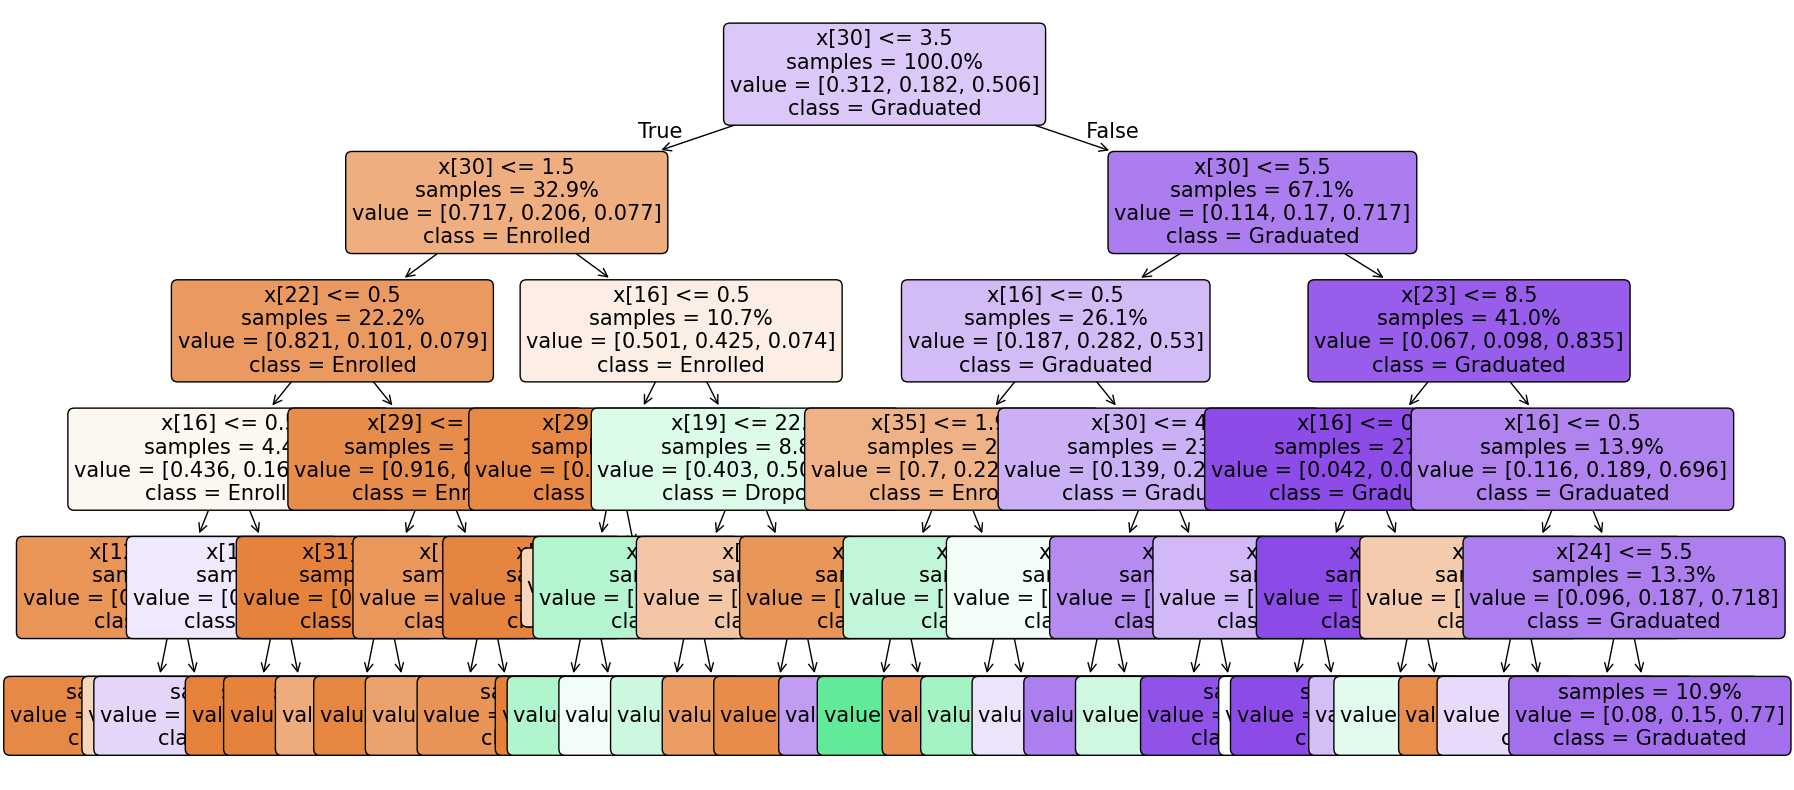

Number of features used: 36


In [40]:
# Decision Tree con GridSearchCV per il pruning
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_params, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)
best_dt = dt_grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Optimized DecisionTree Accuracy on all Dataset: {accuracy_dt:.2%}")
# Lista delle caratteristiche usate per il training
feature_names = X.columns.tolist()

# Visualizza senza i nomi delle caratteristiche per identificare il problema
plt.figure(figsize=(20, 10))
plot_tree(best_dt, filled=True, 
          class_names=['Enrolled', 'Dropout', 'Graduated'],  # Usa i nomi dei target corretti
          rounded=True, 
          fontsize=15, 
          proportion=True,
          impurity=False)
plt.show()
print("Number of features used:", best_dt.n_features_in_)

In [41]:
dot_data = export_graphviz(best_dt, out_file=None, 
                           feature_names=X.columns.tolist(),  # Usa i nomi delle caratteristiche corrette
                           class_names=['Enrolled', 'Dropout', 'Graduated'],  # Usa i nomi delle classi corrette
                           filled=True, rounded=True,  
                           special_characters=True)  

# Converti il dot in un file grafico
graph = pydotplus.graph_from_dot_data(dot_data)

# Salva l'albero decisionale in un file PDF ad alta risoluzione
graph.write_pdf("decision_tree.pdf")

# Visualizza l'albero come immagine (opzionale)
png_str = graph.create_png()
img = PILImage.open(BytesIO(png_str))
img.show()
# Controlla il numero di caratteristiche usate nel modello



ValueError: Length of feature_names, 8 does not match number of features, 36